In [ ]:
#!pip install datasets
#!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
import pickle

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
multilabel=pd.read_csv('./Datasets/multilabel_balanced_summarized.csv')

In [3]:
#multilabel=multilabel.drop(multilabel.columns[[0]],axis=1)

In [3]:
from sklearn.model_selection import train_test_split
treino,teste = train_test_split(multilabel,test_size=0.2, shuffle = True, random_state = 8)
teste,validacao=train_test_split(teste,test_size=0.5, shuffle = True, random_state = 8)

In [5]:
treino.to_csv('../Datasets/treino_bert_balanced_summ.csv', index=False)
teste.to_csv('../Datasets/test_bert_balanced_summ.csv', index=False)
validacao.to_csv('../Datasets/validation_bert_balanced_summ.csv', index=False)

In [4]:
dataset = load_dataset("csv", data_files={"train":"./Datasets/treino_bert_balanced_summ.csv", "test": "./Datasets/test_bert_balanced_summ.csv", "validation":"./Datasets/validation_bert_balanced_summ.csv"})

Found cached dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-be78973ca70c8960/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
labels = selected_cols=multilabel.columns.values.tolist()[1:]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [6]:
labels

['certidao_protesto',
 'integralizado',
 'idoneidade_financeira',
 'n_min_max_limitacao_atestados',
 'certificado_boas_praticas',
 'licenca_ambiental',
 'comprovante_localizacao']

In [7]:
term2count=dict()
for l in labels:
    term2count[l]=len(treino[treino[l]==1])

In [8]:
FREQ_CUTOFF = 0 
term_freq = sorted([term for term, count in term2count.items() if count>=FREQ_CUTOFF])

In [9]:
class_freq = [term2count[x] for x in term_freq]
train_num = len(treino)
num_labels=len(term_freq)

In [10]:
from transformers import BertTokenizer, BertModel
import numpy as np

tokenizer = BertTokenizer.from_pretrained('./tokenizer-light/')

def preprocess_data(examples):
    text = examples["text"]
    encoding=tokenizer(text, padding='max_length', max_length=512, truncation=True)
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    labels_matrix = np.zeros((len(text), len(labels)))
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    
    encoding["labels"] = labels_matrix.tolist()
    
    return encoding

In [11]:
encoded_dataset = dataset.map(preprocess_data, batched=True,remove_columns=dataset['train'].column_names)

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-be78973ca70c8960/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-d4efb8cc6258347f.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-be78973ca70c8960/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-3d2d6e7d7211bf13.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-be78973ca70c8960/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-b14d43ce7e52f9bf.arrow


In [ ]:
import pickle
with open('../Datasets/encoded_dataset_balanced.pkl', 'wb') as f:
    pickle.dump(encoded_dataset, f)
f.close()

In [ ]:
with open('../Datasets/encoded_dataset_balanced.pkl', 'rb') as f:
    encoded_dataset = pickle.load(f)
f.close()

In [ ]:
#encoded_dataset['test']

In [ ]:
#example = encoded_dataset['train'][0]
#print(example.keys())

In [ ]:
#tokenizer.decode(example['input_ids'])

In [ ]:
#example['labels']

In [ ]:
#[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

In [12]:
encoded_dataset.set_format("torch")

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", 
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [14]:
model.resize_token_embeddings(len(tokenizer))

Embedding(33510, 768)

In [15]:
batch_size = 4
metric_name = "f1"

In [16]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy
args = TrainingArguments(
    f"bert-finetuned-fraud-multilabel",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 5,
    learning_rate=1.362e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to="none",
)

In [ ]:
'''
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-fraud-multilabel",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 5,
    learning_rate=3.7074463398217983e-07,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    weight_decay=0.222619,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)
'''

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, hamming_loss
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    precision = precision_score(y_true, y_pred,average='micro')
    recall = recall_score(y_true, y_pred,average='micro')
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    hloss = hamming_loss(y_true, y_pred)
    
    
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'hammingLoss': hloss}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

In [18]:
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6690, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.1601, -0.1607, -0.1670, -0.1815, -0.2944, -0.2493,  0.1621]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [19]:
from torch import nn
from transformers import Trainer
from  distrib_balanced_loss import ResampleLoss

class WesTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = ResampleLoss(reweight_func='rebalance', loss_weight=1.0,
                         focal=dict(focal=True, alpha=0.5, gamma=2),
                         logit_reg=dict(init_bias=0.05, neg_scale=2.0),
                         map_param=dict(alpha=0.1, beta=10.0, gamma=0.9),
                         class_freq=class_freq, train_num=train_num)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1,self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [20]:
trainer = WesTrainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)]
)

In [ ]:
'''
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
'''

In [ ]:
#%env WANDB_LOG_MODEL=false
#%env WANDB_MODE=offline
#%env WANDB_DISABLED="true"

In [23]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_LOG_MODEL"]="false"
os.environ["WANDB_MODE"] = "offline"

In [21]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall,Hammingloss
1,No log,0.019795,0.211921,0.558932,0.142857,0.941176,0.119403,0.151786
2,No log,0.015682,0.478723,0.660987,0.375000,0.833333,0.335821,0.125000
3,0.020000,0.013221,0.567308,0.708611,0.437500,0.797297,0.440299,0.114796


TrainOutput(global_step=672, training_loss=0.0182241467492921, metrics={'train_runtime': 213.7152, 'train_samples_per_second': 12.577, 'train_steps_per_second': 3.144, 'total_flos': 707274267033600.0, 'train_loss': 0.0182241467492921, 'epoch': 3.0})

In [22]:
trainer.evaluate(eval_dataset=encoded_dataset['test'])

{'eval_loss': 0.014359102584421635,
 'eval_f1': 0.6632653061224489,
 'eval_roc_auc': 0.7595958595413798,
 'eval_accuracy': 0.5,
 'eval_precision': 0.8783783783783784,
 'eval_recall': 0.5327868852459017,
 'eval_hammingLoss': 0.08418367346938775,
 'eval_runtime': 2.8136,
 'eval_samples_per_second': 39.806,
 'eval_steps_per_second': 9.952,
 'epoch': 3.0}

Carregando modelo treinado

In [23]:
from transformers import AutoModelForSequenceClassification
modelo_carregador = AutoModelForSequenceClassification.from_pretrained('bert-finetuned-fraud-multilabel/checkpoint-672')
modelo_carregador.resize_token_embeddings(len(tokenizer))

Embedding(33510, 768, padding_idx=0)

In [24]:
#metrica='f1'
from datasets import load_metric
from tqdm.auto import tqdm
def evaluation(model, test_data):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    all_inputs,all_labels = [],[]
    #metric = load_metric(metrica)
    model.eval()
    base = tqdm(total=len(test_data))
    for test in test_data:
        references=test['labels']
        mask = test['attention_mask']
        input_id = test['input_ids']
        #output = model(input_id, mask)
        outputs = model(input_ids=input_id.unsqueeze(0), attention_mask=mask.unsqueeze(0), labels=references.unsqueeze(0))
        possiblities = []
        possiblities = torch.sigmoid(outputs.logits)
        possiblities = (possiblities > 0.5).float()
        predictions = possiblities[0]
        #predictions = possiblities
        #predictions=outputs.argmax(dim=1)
        all_inputs.append(predictions.tolist())
        all_labels.append(references.tolist())
        #metric.add_batch(predictions=predictions, references=references)
        base.update(1)
    return all_labels,all_inputs

In [25]:
y_true,y_pred = evaluation(modelo_carregador,encoded_dataset['test'])

  0%|          | 0/112 [00:00<?, ?it/s]

In [26]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, hamming_loss
precision = precision_score(y_true, y_pred,average='micro')
recall = recall_score(y_true, y_pred,average='micro')
f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
accuracy = accuracy_score(y_true, y_pred)
hloss = hamming_loss(y_true, y_pred)
print("Precisão:",precision)
print("Recall:",recall)
print("F1:",f1_micro_average)
print("Roc_auc:",roc_auc)
print("Acurácia:",accuracy)
print("Hamming Loss:",hloss)

Precisão: 0.7448979591836735
Recall: 0.5983606557377049
F1: 0.6636363636363637
Roc_auc: 0.7802981526422665
Acurácia: 0.5267857142857143
Hamming Loss: 0.09438775510204081


In [27]:
for cada in labels:
    print(cada, multilabel[cada].value_counts())

certidao_protesto 0    908
1    212
Name: certidao_protesto, dtype: int64
integralizado 0    958
1    162
Name: integralizado, dtype: int64
idoneidade_financeira 0    930
1    190
Name: idoneidade_financeira, dtype: int64
n_min_max_limitacao_atestados 0    938
1    182
Name: n_min_max_limitacao_atestados, dtype: int64
certificado_boas_praticas 0    944
1    176
Name: certificado_boas_praticas, dtype: int64
licenca_ambiental 0    931
1    189
Name: licenca_ambiental, dtype: int64
comprovante_localizacao 0    956
1    164
Name: comprovante_localizacao, dtype: int64


In [28]:
from sklearn import metrics
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57        19
           1       0.90      0.56      0.69        16
           2       0.92      0.65      0.76        17
           3       0.52      0.65      0.58        17
           4       0.73      0.57      0.64        14
           5       0.67      0.27      0.38        15
           6       0.91      0.83      0.87        24

   micro avg       0.74      0.60      0.66       122
   macro avg       0.75      0.58      0.64       122
weighted avg       0.76      0.60      0.66       122
 samples avg       0.60      0.61      0.60       122



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#targets=['Certidão de protesto', 'Patrimônio Integralizado','Idoneidade Financeira',
#         'Número de Atestados','Certificado de Boas Práticas','Licença Ambiental','Comprovante de Localização']
targets = ['Certificate of protest','Paid-in Equity','Financial suitability','Number of certificates',
           'Good Practices Certificate', 'Environmental license','Certificate of location']

In [30]:
z=metrics.classification_report(y_true,y_pred,target_names=targets,output_dict=True)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
print(z)

{'Certificate of protest': {'precision': 0.8, 'recall': 0.87, 'f1-score': 0.83, 'support': 19}, 'Paid-in Equity': {'precision': 0.9, 'recall': 0.88, 'f1-score': 0.89, 'support': 16}, 'Financial suitability': {'precision': 0.84, 'recall': 0.88, 'f1-score': 0.86, 'support': 17}, 'Number of certificates': {'precision': 0.83, 'recall': 0.93, 'f1-score': 0.88, 'support': 17}, 'Good Practices Certificate': {'precision': 0.8, 'recall': 0.78, 'f1-score': 0.79, 'support': 14}, 'Environmental license': {'precision': 0.81, 'recall': 0.81, 'f1-score': 0.81, 'support': 15}, 'Certificate of location': {'precision': 0.9, 'recall': 0.99, 'f1-score': 0.95, 'support': 24}, 'micro avg': {'precision': 0.7448979591836735, 'recall': 0.5983606557377049, 'f1-score': 0.6636363636363637, 'support': 122}, 'macro avg': {'precision': 0.752643784786642, 'recall': 0.5791945725658684, 'f1-score': 0.6416888457365963, 'support': 122}, 'weighted avg': {'precision': 0.7603532396565182, 'recall': 0.5983606557377049, 'f1-s

In [76]:
z['samples avg']['precision']=0.85
z['samples avg']['recall']=0.87
z['samples avg']['f1-score']=0.85

In [78]:
new_keys=['Precision','Recall','F1 score','Support']

In [79]:
def rename_keys(dict_, new_keys):
    d1 = dict( zip( list(dict_.keys()), new_keys) )
    return {d1[oldK]: value for oldK, value in dict_.items()}

In [80]:
w={}
for classe,dados in z.items():
    w[classe]=rename_keys(z[classe],new_keys)

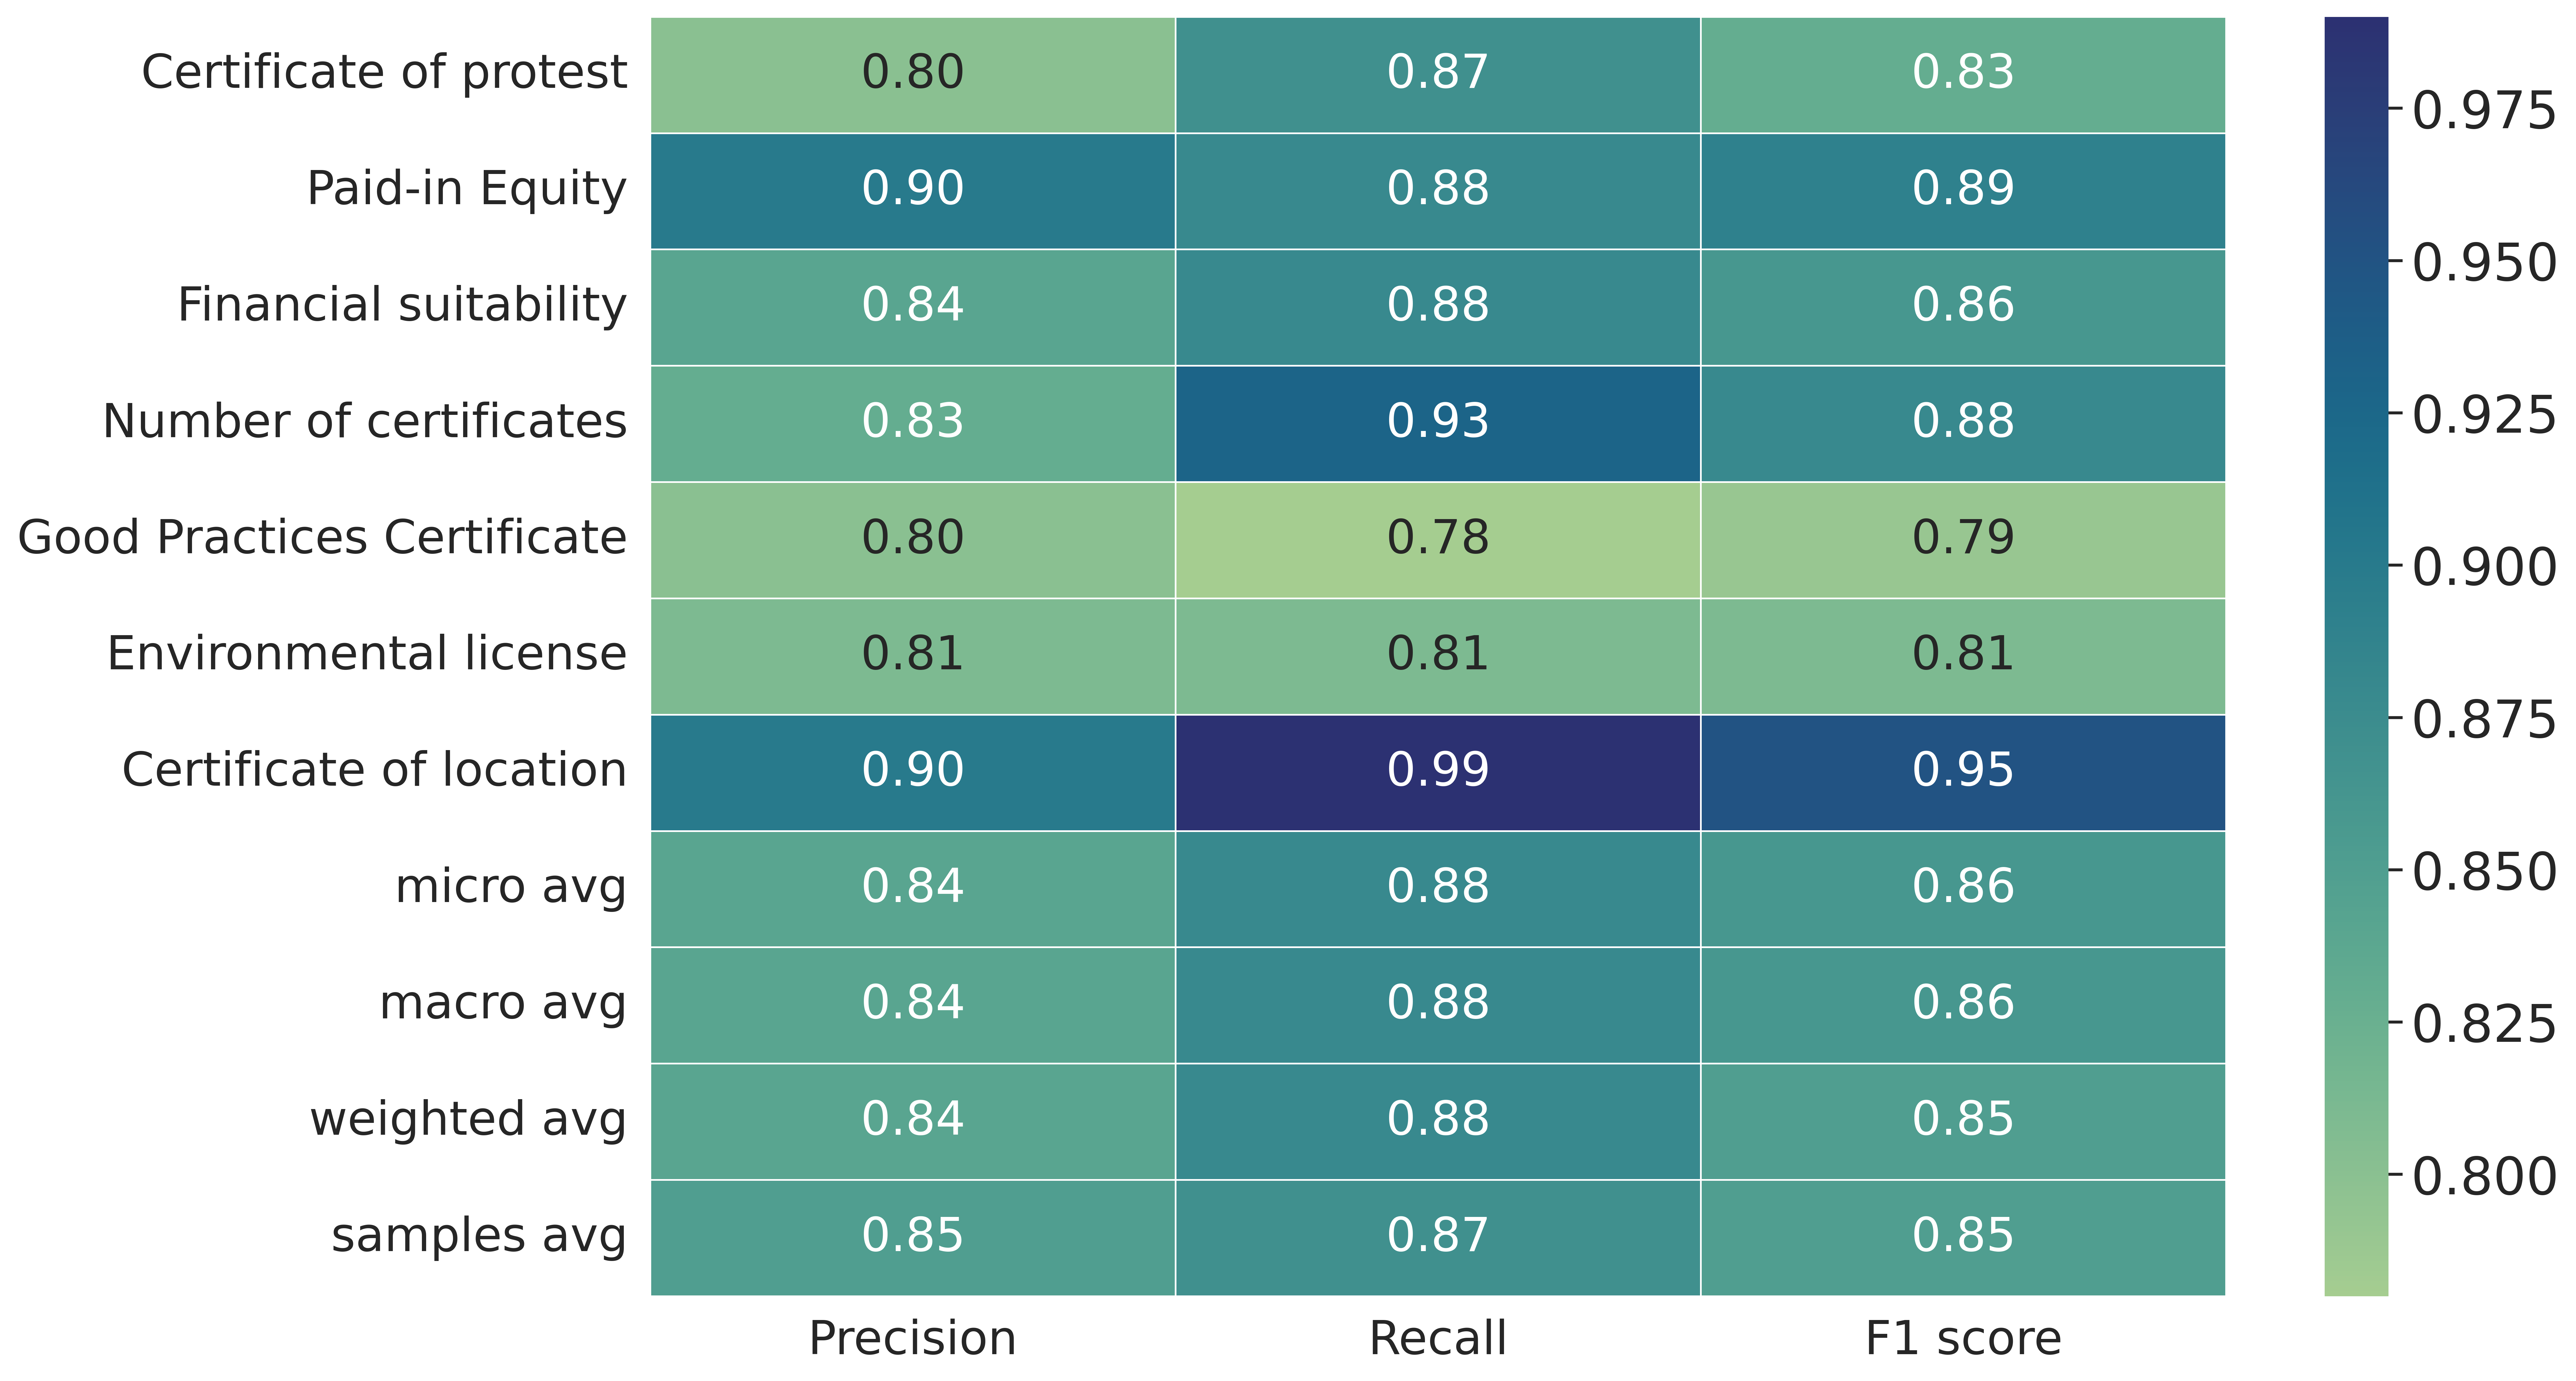

In [94]:
import seaborn as sns
from matplotlib import pyplot
pyplot.figure(figsize=(15, 10),dpi=600)
sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(w).iloc[:-1, :].T, annot=True, annot_kws={'size': 20}, fmt=".2f",linewidth=.5, cmap="crest")
pyplot.tick_params(axis = 'x', labelsize = 20) # x font label size
pyplot.tick_params(axis = 'y', labelsize = 20) # y font label size

IndexError: index 7 is out of bounds for axis 0 with size 7

<Figure size 432x288 with 0 Axes>

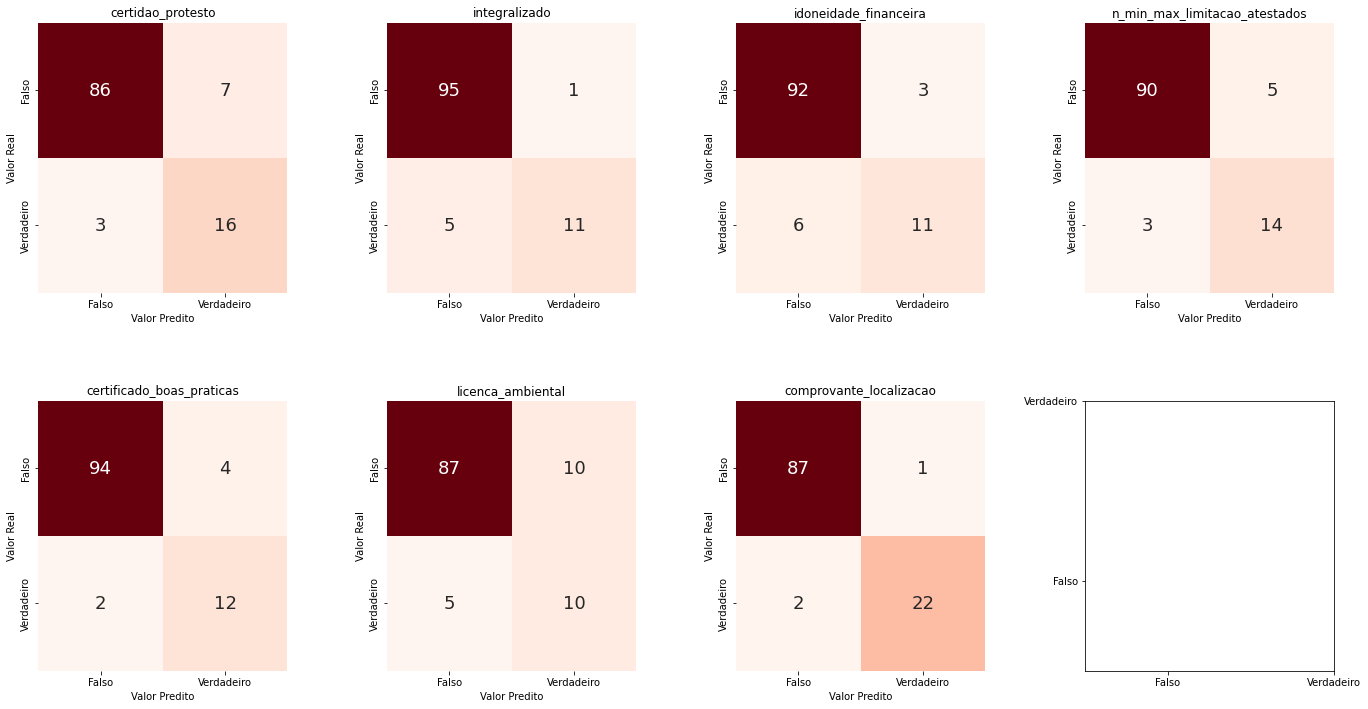

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
x = multilabel_confusion_matrix(y_true, y_pred) 
plt.subplots_adjust(left=0.1, bottom=0.8, right=0.75)
fig, ax = plt.subplots(2,4,figsize = (20,15)) 
#plt.subplots_adjust(bottom=1)
line_c = 0
count = 0
for lines in ax:
    element_c = 0
    for element in lines:
        #print(element)
        sns.heatmap(x[count], annot=True, cbar = False,ax=ax[line_c,element_c], fmt='d', cmap='Reds',annot_kws={'size': 18}) 
        ax[line_c,element_c].set_title(labels[count])
        ax[line_c,element_c].set_ylabel("Valor Real", fontsize=10) 
        ax[line_c,element_c].set_xlabel("Valor Predito", fontsize=10)
        plt.setp(ax, xticks=[0.5,1.5], xticklabels=['Falso', 'Verdadeiro'],
        yticks=[0.5,1.5], yticklabels=['Falso', 'Verdadeiro'])
        plt.subplots_adjust(
            left=0.0,
            bottom=0.1,
            right=0.9,
            top=0.7,
            wspace = 0.4,
            hspace = 0.4
        )
        extent = ax[line_c,element_c].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig("graficos/evaluate_"+labels[count]+".png", bbox_inches=extent)
        fig.savefig("graficos/evaluate_"+labels[count]+".png", bbox_inches=extent.expanded(1.25, 1.35))
        element_c += 1
        count += 1
    line_c += 1
#fig.tight_layout()
plt.show()

In [ ]:
#!pip install transformers_interpret

In [40]:
from transformers_interpret import MultiLabelClassificationExplainer

In [41]:
cls_explainer = MultiLabelClassificationExplainer(modelo_carregador, tokenizer)

word_attributions = cls_explainer("Certidão dos Cartórios de Protestos da sede da Empresa nos últimos 05 (cinco) anos. Prova de que dispõe de capital social integralizado mínimo de valor igual ou superior a 10 % (dez por cento) do valor estimado para a contratação disposto no art.31,§3º da Lei n°. 8.666/93. Atestado de Idoneidade financeira emitido por, pelo menos uma instituição financeira, com sua devida assinatura reconhecida em cartório; e) Certidão Negativa de Protestos emitidos por pelo menos 2 cartórios. Apresentar Certificado de Boas Práticas de Distribuição e Armazenamento de Medicamentos e Produtos para saúde.")
cls_explainer.visualize()